<a href="https://colab.research.google.com/github/thedatasense/medgemma-explainer/blob/master/tutorial_optimized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MedGemma Explainability Tutorial (Memory-Optimized)

## Implementing Chefer et al. for Vision-Language Model Interpretability

This tutorial demonstrates how to generate explanations for MedGemma predictions using the gradient-weighted attention method from Chefer et al. (2021).

**Memory Optimized**: This version is designed to run on GPUs with limited memory (tested on A100 80GB).

**Reference:** Chefer, H., Gur, S., & Wolf, L. (2021). *Transformer Interpretability Beyond Attention Visualization.* CVPR 2021.

## Table of Contents

1. [Setup and Dependencies](#1-setup)
2. [Memory Management Utilities](#2-memory)
3. [Loading MedGemma](#3-loading-model)
4. [Method Overview](#4-method)
5. [Memory-Efficient Explainer](#5-explainer)
6. [Basic Usage with Test Images](#6-basic-usage)
7. [Medical Imaging: Chest X-ray Analysis](#7-chest-xray)
8. [Keyword Explanation](#8-keyword)
9. [Limitations and Summary](#9-summary)

## 1. Setup and Dependencies <a name="1-setup"></a>

In [ ]:
# Install dependencies if needed
# !pip install transformers accelerate pillow matplotlib -q

In [1]:
# Setup HuggingFace authentication
from google.colab import userdata
import os

hf_token = userdata.get('HF_TOKEN')
os.environ['HF_TOKEN'] = hf_token

from huggingface_hub import login
login(token=hf_token, add_to_git_credential=False)
print("HuggingFace authentication successful!")

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


HuggingFace authentication successful!


In [2]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import gc
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB
GPU Memory: 85.2 GB


## 2. Memory Management Utilities <a name="2-memory"></a>

Critical for running on limited GPU memory.

In [3]:
def get_gpu_memory():
    """Get current GPU memory usage in GB."""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1e9
        reserved = torch.cuda.memory_reserved() / 1e9
        return allocated, reserved
    return 0, 0

def print_memory(msg=""):
    """Print current GPU memory status."""
    allocated, reserved = get_gpu_memory()
    print(f"{msg} | GPU Memory: {allocated:.2f}GB allocated, {reserved:.2f}GB reserved")

def clear_memory():
    """Aggressively clear GPU memory."""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

print_memory("Initial state")

Initial state | GPU Memory: 0.00GB allocated, 0.00GB reserved


## 3. Loading MedGemma <a name="3-loading-model"></a>

**Critical settings:**
- `attn_implementation='eager'`: Required for attention output (SDPA doesn't support it)
- `torch_dtype=torch.bfloat16`: Reduces memory by half
- `low_cpu_mem_usage=True`: Reduces peak memory during loading

In [4]:
from transformers import AutoProcessor, AutoModelForImageTextToText

MODEL_NAME = "google/medgemma-1.5-4b-it"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Loading {MODEL_NAME}...")
print_memory("Before loading")

processor = AutoProcessor.from_pretrained(MODEL_NAME, trust_remote_code=True)

model = AutoModelForImageTextToText.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True,
    attn_implementation="eager",
    low_cpu_mem_usage=True,
)
model.eval()

print_memory("After loading")
print("\nModel loaded successfully!")

Loading google/medgemma-1.5-4b-it...
Before loading | GPU Memory: 0.00GB allocated, 0.00GB reserved


processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.55k [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

After loading | GPU Memory: 8.60GB allocated, 8.62GB reserved

Model loaded successfully!


In [5]:
# MedGemma constants
NUM_LAYERS = 34
NUM_IMAGE_TOKENS = 256
IMAGE_START_IDX = 6
GLOBAL_LAYERS = [5, 11, 17, 23, 29]  # Layers with full context attention

def is_global_layer(idx):
    """Check if layer uses global (full context) attention."""
    return idx in GLOBAL_LAYERS

print(f"Architecture: {NUM_LAYERS} layers, {NUM_IMAGE_TOKENS} image tokens")
print(f"Global attention layers: {GLOBAL_LAYERS}")

Architecture: 34 layers, 256 image tokens
Global attention layers: [5, 11, 17, 23, 29]


## 4. Method Overview <a name="4-method"></a>

### Chefer et al. Core Equations

**Equation 5: Gradient-Weighted Attention**
$$\bar{A} = \mathbb{E}_h \left[ (\nabla A \odot A)^+ \right]$$

**Equation 6: Relevancy Propagation**
$$R = R + \bar{A} \cdot R$$

### Critical: Correct Backprop Target for Causal LM

For causal language models, logit at position `i` predicts token at position `i+1`.

To explain why token at position `p` was generated:
1. Backprop from logit at position `p-1`
2. Use the actual token id at position `p`
3. Extract relevancy from row `p-1` in the R matrix

## 5. Memory-Efficient Explainer <a name="5-explainer"></a>

This implementation processes attention layers incrementally to minimize peak memory usage.

In [6]:
@dataclass
class ExplanationResult:
    """Container for explanation results."""
    image_relevancy: np.ndarray      # 16x16 heatmap
    text_relevancy: np.ndarray       # Per-token relevancy
    token_labels: List[str]          # Decoded tokens
    generated_text: str              # Full response
    target_token: str                # Token being explained
    target_position: int             # Position in sequence

In [7]:
def prepare_inputs(image, prompt, processor, device):
    """Prepare model inputs from image and prompt."""
    messages = [{'role': 'user', 'content': [
        {'type': 'image', 'image': image},
        {'type': 'text', 'text': prompt}
    ]}]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=text, images=image, return_tensors='pt').to(device)
    return inputs


def generate_response(model, inputs, processor, max_new_tokens=50):
    """Generate model response."""
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False
        )

    full_text = processor.decode(outputs[0], skip_special_tokens=True)
    if 'model' in full_text:
        response = full_text.split('model')[-1].strip()
    else:
        response = full_text

    return outputs, response


def find_keyword_position(gen_outputs, processor, keyword):
    """Find the position of a keyword in generated tokens."""
    tokens = [processor.decode([t]) for t in gen_outputs[0]]

    # Try exact match first
    for i, tok in enumerate(tokens):
        if keyword.lower() == tok.strip().lower():
            return i

    # Try substring match
    for i, tok in enumerate(tokens):
        if keyword.lower() in tok.lower():
            return i

    return None

In [8]:
def compute_relevancy_memory_efficient(
    model,
    gen_outputs,
    pixel_values,
    target_token_position: int,
    device: str = "cuda",
    use_global_only: bool = False,
) -> torch.Tensor:
    """
    Compute relevancy matrix using Chefer method with memory optimization.

    Args:
        model: MedGemma model
        gen_outputs: Generated token ids
        pixel_values: Processed image tensor
        target_token_position: Position of token to explain
        device: Device to use
        use_global_only: If True, only use global attention layers (faster, less memory)

    Returns:
        Relevancy matrix R
    """
    clear_memory()

    seq_len = gen_outputs.shape[1]
    logit_position = target_token_position - 1
    target_token_id = gen_outputs[0, target_token_position].item()

    # Initialize relevancy matrix
    R = torch.eye(seq_len, device=device, dtype=torch.float32)

    # Determine which layers to process
    if use_global_only:
        layers_to_process = GLOBAL_LAYERS
    else:
        layers_to_process = list(range(NUM_LAYERS))

    # Prepare inputs
    full_inputs = {
        'input_ids': gen_outputs,
        'attention_mask': torch.ones_like(gen_outputs),
        'pixel_values': pixel_values,
    }

    # Forward pass with attention output
    with torch.enable_grad():
        outputs = model(**full_inputs, output_attentions=True, return_dict=True)

        # Retain gradients on attention tensors for layers we care about
        for i in layers_to_process:
            attn = outputs.attentions[i]
            if attn is not None:
                attn.requires_grad_(True)
                attn.retain_grad()

        # Backward pass from correct position
        target_logit = outputs.logits[0, logit_position, target_token_id]
        target_logit.backward()

    # Process each layer
    for layer_idx in layers_to_process:
        attn = outputs.attentions[layer_idx]
        if attn is None or attn.grad is None:
            continue

        # Get attention and gradient, convert to float32
        A = attn.detach().float().squeeze(0)  # [heads, seq, seq]
        grad_A = attn.grad.detach().float().squeeze(0)

        # Equation 5: Ā = E_h[(∇A ⊙ A)⁺]
        weighted = (grad_A * A).clamp(min=0)
        A_bar = weighted.mean(dim=0)  # Average over heads

        # Equation 6: R = R + Ā @ R
        R = R + A_bar @ R

        # Free memory for this layer
        del A, grad_A, weighted, A_bar

    # Clear the computation graph
    del outputs
    clear_memory()

    return R, logit_position

In [9]:
def extract_relevancy(
    R: torch.Tensor,
    logit_position: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Extract image and text relevancy from R matrix.

    Returns:
        image_relevancy: 16x16 numpy array
        text_relevancy: 1D numpy array for text tokens
    """
    # Extract relevancy row for the target position
    token_relevancy = R[logit_position, :].cpu().numpy()

    # Split into image and text portions
    image_start = IMAGE_START_IDX
    image_end = IMAGE_START_IDX + NUM_IMAGE_TOKENS

    image_relevancy = token_relevancy[image_start:image_end]
    text_relevancy = token_relevancy[image_end:]

    # Reshape image relevancy to 16x16 grid
    image_relevancy_2d = image_relevancy.reshape(16, 16)

    # Normalize to [0, 1]
    def normalize(arr):
        arr_min, arr_max = arr.min(), arr.max()
        if arr_max - arr_min > 1e-8:
            return (arr - arr_min) / (arr_max - arr_min)
        return arr - arr_min

    image_relevancy_2d = normalize(image_relevancy_2d)
    text_relevancy = normalize(text_relevancy)

    return image_relevancy_2d, text_relevancy

In [10]:
def explain(
    model,
    processor,
    image,
    prompt: str,
    target_token_position: Optional[int] = None,
    keyword: Optional[str] = None,
    max_new_tokens: int = 50,
    use_global_only: bool = False,
    device: str = "cuda",
) -> ExplanationResult:
    """
    Generate explanation for MedGemma prediction.

    Args:
        model: MedGemma model
        processor: MedGemma processor
        image: PIL Image
        prompt: Text prompt
        target_token_position: Position of token to explain (default: last token)
        keyword: If provided, find and explain this keyword in response
        max_new_tokens: Maximum tokens to generate (keep low for memory)
        use_global_only: Use only global attention layers (faster, less memory)
        device: Device to use

    Returns:
        ExplanationResult with image and text relevancy
    """
    clear_memory()
    print_memory("Start of explain()")

    # Prepare inputs
    inputs = prepare_inputs(image, prompt, processor, device)

    # Generate response
    gen_outputs, response_text = generate_response(
        model, inputs, processor, max_new_tokens
    )
    print(f"Generated: {response_text[:100]}...")
    print_memory("After generation")

    # Determine target position
    if keyword is not None:
        target_pos = find_keyword_position(gen_outputs, processor, keyword)
        if target_pos is None:
            raise ValueError(f"Keyword '{keyword}' not found in response")
        print(f"Found keyword '{keyword}' at position {target_pos}")
    elif target_token_position is not None:
        target_pos = target_token_position
    else:
        target_pos = gen_outputs.shape[1] - 1  # Last token

    target_token = processor.decode([gen_outputs[0, target_pos].item()])
    print(f"Explaining token: '{target_token}' at position {target_pos}")

    # Compute relevancy
    R, logit_position = compute_relevancy_memory_efficient(
        model,
        gen_outputs,
        inputs['pixel_values'],
        target_pos,
        device=device,
        use_global_only=use_global_only,
    )
    print_memory("After relevancy computation")

    # Extract relevancy
    image_relevancy, text_relevancy = extract_relevancy(R, logit_position)

    # Get token labels
    text_start = IMAGE_START_IDX + NUM_IMAGE_TOKENS
    token_labels = [processor.decode([t.item()]) for t in gen_outputs[0, text_start:]]

    # Cleanup
    del R, gen_outputs, inputs
    clear_memory()
    print_memory("After cleanup")

    return ExplanationResult(
        image_relevancy=image_relevancy,
        text_relevancy=text_relevancy,
        token_labels=token_labels,
        generated_text=response_text,
        target_token=target_token,
        target_position=target_pos,
    )

In [11]:
def visualize_explanation(
    image,
    result: ExplanationResult,
    title: Optional[str] = None,
    show_text_relevancy: bool = True,
):
    """
    Visualize explanation results.
    """
    n_cols = 3 if show_text_relevancy else 2
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 5))

    # Original image
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Heatmap overlay
    heatmap = result.image_relevancy
    heatmap_resized = np.array(
        Image.fromarray((heatmap * 255).astype(np.uint8)).resize(
            image.size, Image.BILINEAR
        )
    ) / 255.0

    axes[1].imshow(image)
    im = axes[1].imshow(heatmap_resized, cmap='jet', alpha=0.5, vmin=0, vmax=1)
    axes[1].set_title(f"Relevancy for '{result.target_token.strip()}'")
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046)

    # Text relevancy
    if show_text_relevancy and len(result.text_relevancy) > 0:
        n_tokens = min(15, len(result.text_relevancy))
        sorted_idx = np.argsort(result.text_relevancy)[::-1][:n_tokens]

        labels = [result.token_labels[i][:15].replace('\n', '\\n') for i in sorted_idx]
        values = [result.text_relevancy[i] for i in sorted_idx]

        axes[2].barh(range(len(labels)), values, color='steelblue')
        axes[2].set_yticks(range(len(labels)))
        axes[2].set_yticklabels(labels, fontsize=9)
        axes[2].invert_yaxis()
        axes[2].set_xlabel('Relevancy')
        axes[2].set_title('Top Text Tokens')

    if title:
        fig.suptitle(title, fontsize=12, y=1.02)

    plt.tight_layout()
    return fig

## 6. Basic Usage with Test Images <a name="6-basic-usage"></a>

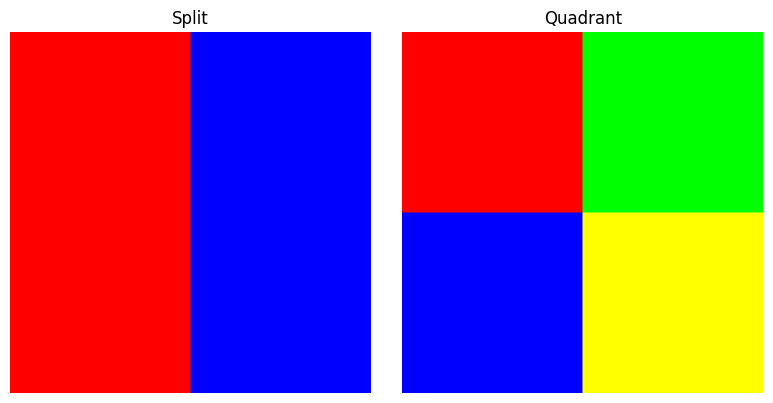

In [12]:
def create_test_image(pattern='split'):
    """Create simple test images."""
    img = np.zeros((224, 224, 3), dtype=np.uint8)

    if pattern == 'split':
        img[:, :112, 0] = 255  # Left red
        img[:, 112:, 2] = 255  # Right blue
    elif pattern == 'quadrant':
        img[:112, :112, 0] = 255      # Red top-left
        img[:112, 112:, 1] = 255      # Green top-right
        img[112:, :112, 2] = 255      # Blue bottom-left
        img[112:, 112:] = [255, 255, 0]  # Yellow bottom-right

    return Image.fromarray(img)

# Display test images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for ax, pattern in zip(axes, ['split', 'quadrant']):
    ax.imshow(create_test_image(pattern))
    ax.set_title(f'{pattern.capitalize()}')
    ax.axis('off')
plt.tight_layout()
plt.show()

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Running explanation (global layers only for speed)...
Start of explain() | GPU Memory: 8.60GB allocated, 8.62GB reserved
Generated: The image shows two distinct colors:

*   **Red:** The left side of the image is filled with a brigh...
After generation | GPU Memory: 8.62GB allocated, 13.05GB reserved
Explaining token: '   ' at position 307
After relevancy computation | GPU Memory: 17.26GB allocated, 24.39GB reserved
After cleanup | GPU Memory: 17.25GB allocated, 24.23GB reserved

Generated: The image shows two distinct colors:

*   **Red:** The left side of the image is filled with a bright red color.
*


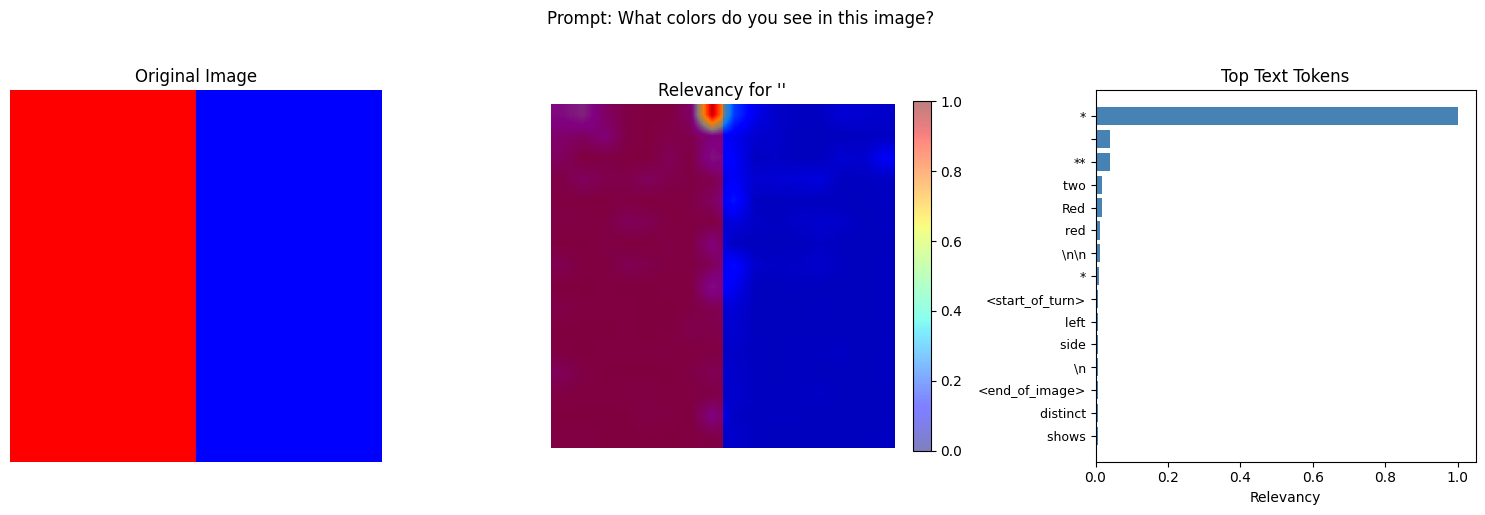

In [13]:
# Test with split image
test_image = create_test_image('split')
prompt = "What colors do you see in this image?"

print("Running explanation (global layers only for speed)...")
result = explain(
    model, processor, test_image, prompt,
    max_new_tokens=30,
    use_global_only=True,  # Faster, less memory
    device=DEVICE
)

print(f"\nGenerated: {result.generated_text}")
fig = visualize_explanation(test_image, result, title=f"Prompt: {prompt}")
plt.show()

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Explaining keyword 'red'...
Start of explain() | GPU Memory: 17.25GB allocated, 24.23GB reserved
Generated: The image shows two distinct colors:

*   **Red:** The left side of the image is filled with a brigh...
After generation | GPU Memory: 17.26GB allocated, 26.41GB reserved
Found keyword 'red' at position 289
Explaining token: 'Red' at position 289
After relevancy computation | GPU Memory: 17.26GB allocated, 25.47GB reserved
After cleanup | GPU Memory: 17.25GB allocated, 24.23GB reserved


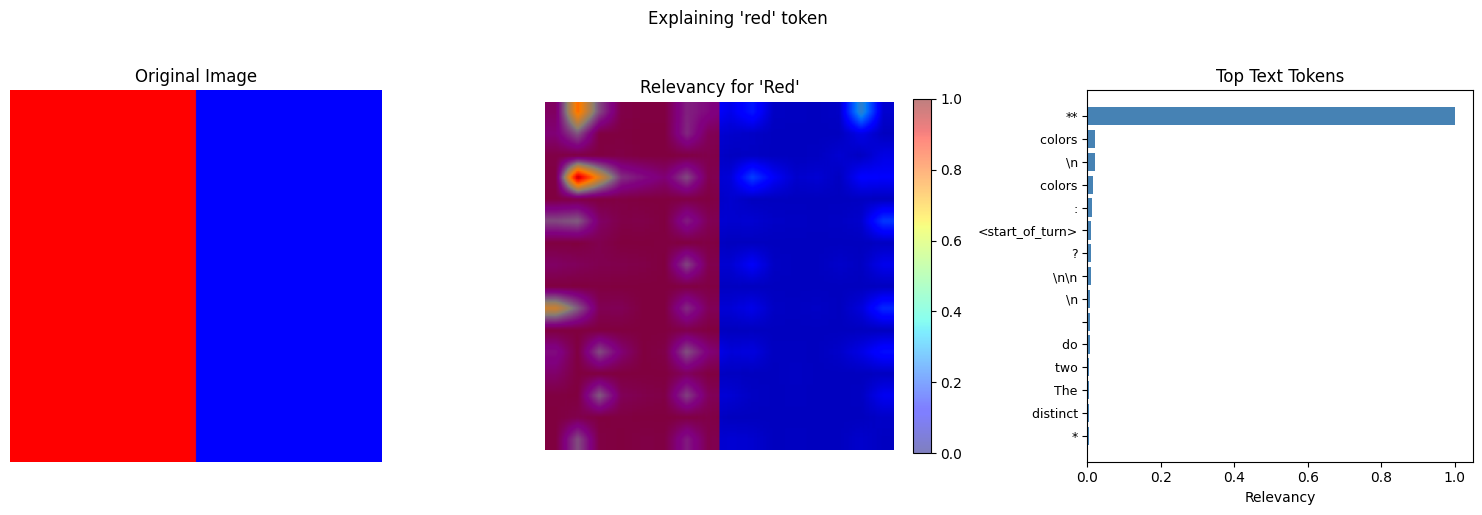

In [14]:
# Explain specific keyword "red"
clear_memory()

print("Explaining keyword 'red'...")
try:
    result_red = explain(
        model, processor, test_image, prompt,
        keyword="red",
        max_new_tokens=30,
        use_global_only=True,
        device=DEVICE
    )
    fig = visualize_explanation(test_image, result_red, title="Explaining 'red' token")
    plt.show()
except ValueError as e:
    print(f"Could not find keyword: {e}")

## 7. Medical Imaging: Chest X-ray Analysis <a name="7-chest-xray"></a>

**Important for Chest X-rays (PA View):**
- Left side of image = Patient's RIGHT side
- Right side of image = Patient's LEFT side

Downloaded chest X-ray


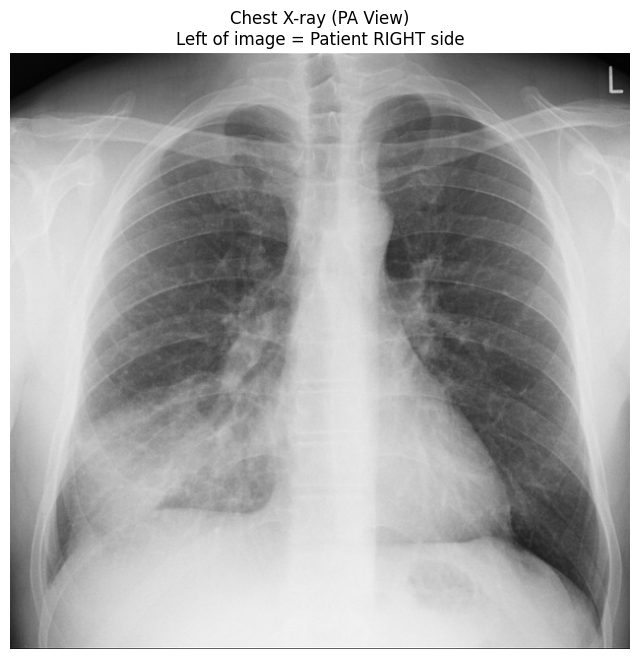

In [15]:
# Load chest X-ray
import os

if os.path.exists('/content/chest_xray.jpg'):
    chest_xray = Image.open('/content/chest_xray.jpg').convert('RGB')
    print("Loaded local chest X-ray")
else:
    url = "https://prod-images-static.radiopaedia.org/images/1371188/0a1f5edc85aa58d5780928cb39b08659c1fc4d6d7c7dce2f8db1d63c7c737234_big_gallery.jpeg"
    response = requests.get(url)
    chest_xray = Image.open(BytesIO(response.content)).convert('RGB')
    print("Downloaded chest X-ray")

# Display
plt.figure(figsize=(8, 8))
plt.imshow(chest_xray, cmap='gray')
plt.title('Chest X-ray (PA View)\nLeft of image = Patient RIGHT side')
plt.axis('off')
plt.show()

In [16]:
# Analyze for pneumonia
clear_memory()

medical_prompt = "Is there evidence of pneumonia in this chest X-ray?"

print(f"Prompt: {medical_prompt}")
print("Analyzing...")

result_xray = explain(
    model, processor, chest_xray, medical_prompt,
    max_new_tokens=50,
    use_global_only=True,
    device=DEVICE
)

print(f"\nMedGemma's Assessment:\n{result_xray.generated_text}")

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Prompt: Is there evidence of pneumonia in this chest X-ray?
Analyzing...
Start of explain() | GPU Memory: 17.25GB allocated, 24.23GB reserved
Generated: Yes, there is evidence of pneumonia in the right lower lobe of the lung. The right lower lobe appear...
After generation | GPU Memory: 17.26GB allocated, 26.41GB reserved
Explaining token: ' a' at position 330
After relevancy computation | GPU Memory: 17.26GB allocated, 25.48GB reserved
After cleanup | GPU Memory: 17.25GB allocated, 24.23GB reserved

MedGemma's Assessment:
Yes, there is evidence of pneumonia in the right lower lobe of the lung. The right lower lobe appears denser than the left, and there is an opacity in the lower portion of the right lung. This could be due to consolidation, which is a


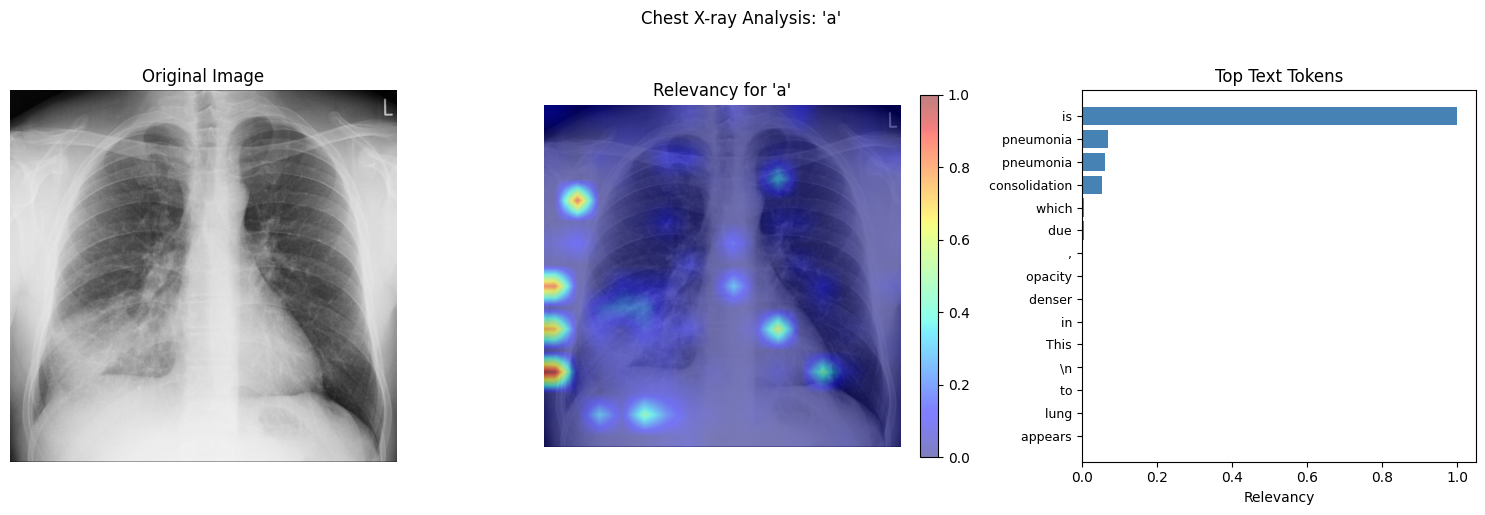

In [17]:
# Visualize
fig = visualize_explanation(
    chest_xray, result_xray,
    title=f"Chest X-ray Analysis: '{result_xray.target_token.strip()}'"
)
plt.show()

In [18]:
# Region analysis for chest X-ray
def analyze_chest_regions(heatmap):
    """Analyze relevancy by anatomical region."""
    h, w = heatmap.shape
    mid_h, mid_w = h // 2, w // 2

    # In PA view: left of image = patient's right
    regions = {
        'Pt RIGHT upper': heatmap[:mid_h, :mid_w].mean(),
        'Pt LEFT upper': heatmap[:mid_h, mid_w:].mean(),
        'Pt RIGHT lower': heatmap[mid_h:, :mid_w].mean(),
        'Pt LEFT lower': heatmap[mid_h:, mid_w:].mean(),
    }

    pt_right = (regions['Pt RIGHT upper'] + regions['Pt RIGHT lower']) / 2
    pt_left = (regions['Pt LEFT upper'] + regions['Pt LEFT lower']) / 2

    return regions, pt_right, pt_left

regions, pt_right, pt_left = analyze_chest_regions(result_xray.image_relevancy)

print("Region Analysis:")
print("(Note: Left of image = Patient's RIGHT side)\n")
for name, val in regions.items():
    print(f"  {name}: {val:.4f}")
print(f"\n  Patient RIGHT avg: {pt_right:.4f}")
print(f"  Patient LEFT avg:  {pt_left:.4f}")
print(f"  RIGHT/LEFT ratio:  {pt_right/pt_left:.2f}x")

Region Analysis:
(Note: Left of image = Patient's RIGHT side)

  Pt RIGHT upper: 0.0393
  Pt LEFT upper: 0.0251
  Pt RIGHT lower: 0.0998
  Pt LEFT lower: 0.0344

  Patient RIGHT avg: 0.0695
  Patient LEFT avg:  0.0297
  RIGHT/LEFT ratio:  2.34x


## 8. Keyword Explanation <a name="8-keyword"></a>

Explain specific words in the model's response.

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



Trying keyword: 'pneumonia'
Start of explain() | GPU Memory: 17.25GB allocated, 24.23GB reserved
Generated: Yes, there is evidence of pneumonia in the right lower lobe of the lung. The right lower lobe appear...
After generation | GPU Memory: 17.26GB allocated, 26.41GB reserved
Found keyword 'pneumonia' at position 268
Explaining token: ' pneumonia' at position 268
After relevancy computation | GPU Memory: 17.26GB allocated, 25.48GB reserved
After cleanup | GPU Memory: 17.25GB allocated, 24.23GB reserved
  Found! Pt RIGHT: 0.093, Pt LEFT: 0.025, Ratio: 3.76x


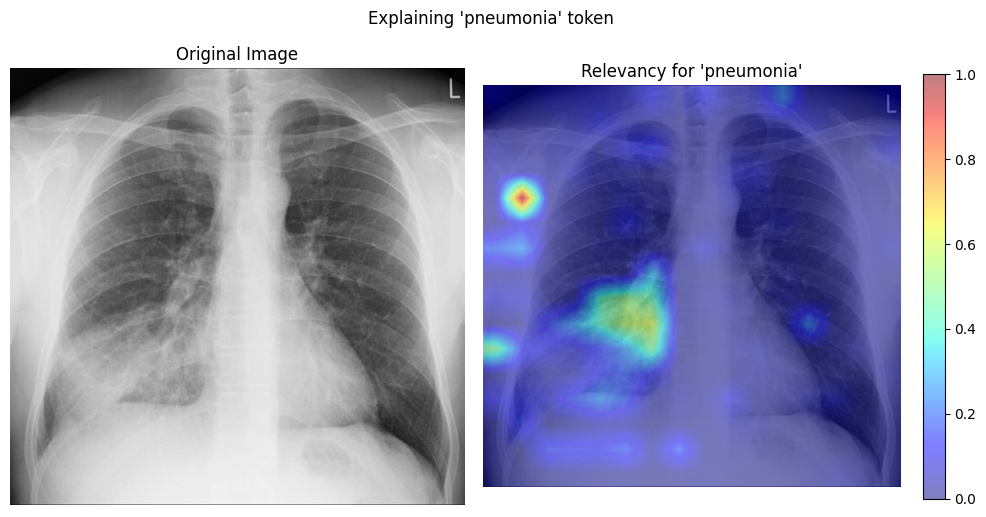

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



Trying keyword: 'right'
Start of explain() | GPU Memory: 17.25GB allocated, 24.23GB reserved
Generated: Yes, there is evidence of pneumonia in the right lower lobe of the lung. The right lower lobe appear...
After generation | GPU Memory: 17.26GB allocated, 26.41GB reserved
Found keyword 'right' at position 290
Explaining token: ' right' at position 290
After relevancy computation | GPU Memory: 17.26GB allocated, 25.48GB reserved
After cleanup | GPU Memory: 17.25GB allocated, 24.23GB reserved
  Found! Pt RIGHT: 0.062, Pt LEFT: 0.012, Ratio: 5.34x


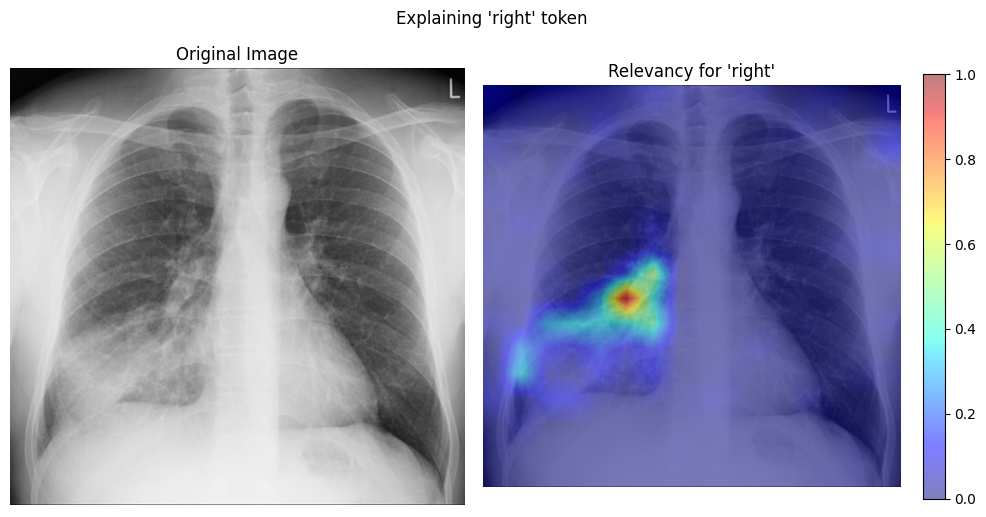

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



Trying keyword: 'lung'
Start of explain() | GPU Memory: 17.25GB allocated, 24.23GB reserved
Generated: Yes, there is evidence of pneumonia in the right lower lobe of the lung. The right lower lobe appear...
After generation | GPU Memory: 17.26GB allocated, 26.41GB reserved
Found keyword 'lung' at position 295
Explaining token: ' lung' at position 295
After relevancy computation | GPU Memory: 17.26GB allocated, 25.48GB reserved
After cleanup | GPU Memory: 17.25GB allocated, 24.23GB reserved
  Found! Pt RIGHT: 0.114, Pt LEFT: 0.060, Ratio: 1.90x


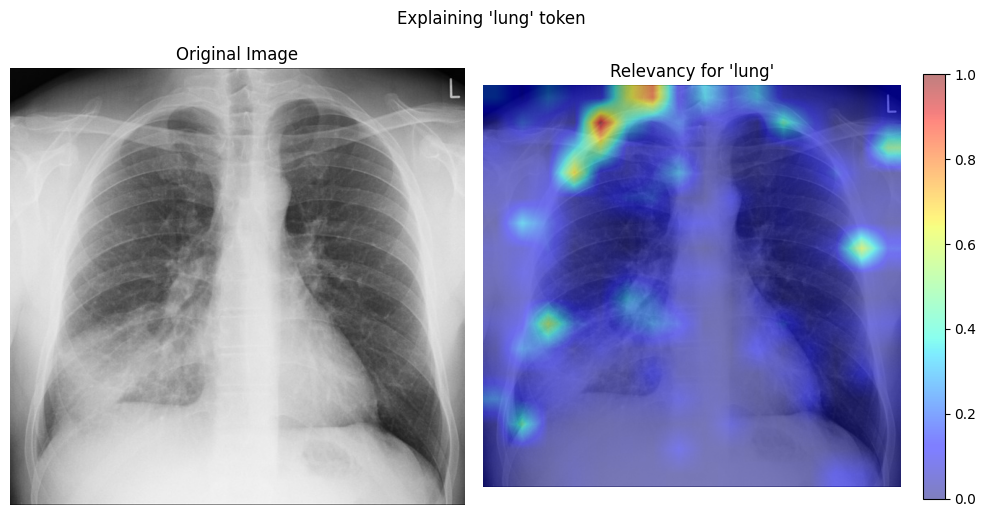

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



Trying keyword: 'consolidation'
Start of explain() | GPU Memory: 17.25GB allocated, 24.23GB reserved
Generated: Yes, there is evidence of pneumonia in the right lower lobe of the lung. The right lower lobe appear...
After generation | GPU Memory: 17.26GB allocated, 26.41GB reserved
Found keyword 'consolidation' at position 326
Explaining token: ' consolidation' at position 326
After relevancy computation | GPU Memory: 17.26GB allocated, 25.48GB reserved
After cleanup | GPU Memory: 17.25GB allocated, 24.23GB reserved
  Found! Pt RIGHT: 0.064, Pt LEFT: 0.012, Ratio: 5.39x


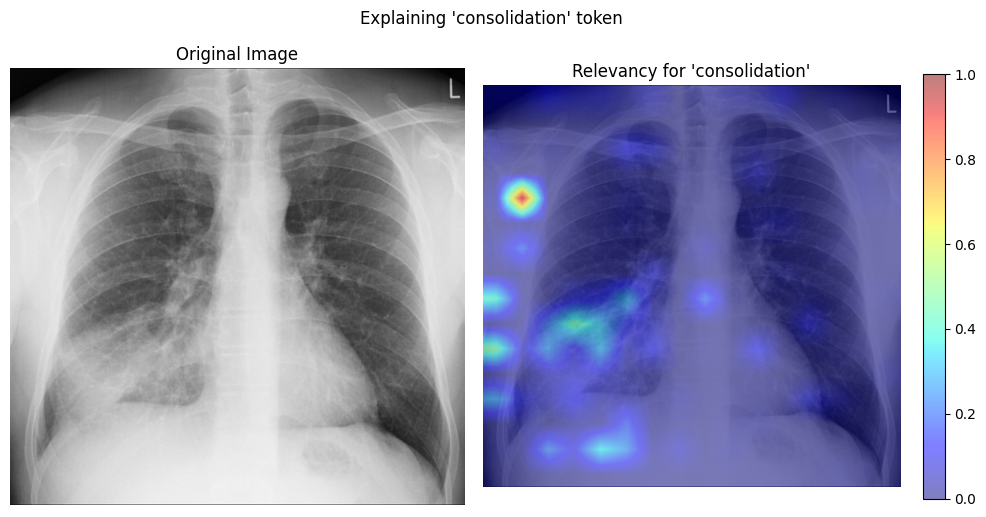

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



Trying keyword: 'opacity'
Start of explain() | GPU Memory: 17.25GB allocated, 24.23GB reserved
Generated: Yes, there is evidence of pneumonia in the right lower lobe of the lung. The right lower lobe appear...
After generation | GPU Memory: 17.26GB allocated, 26.41GB reserved
Found keyword 'opacity' at position 311
Explaining token: ' opacity' at position 311
After relevancy computation | GPU Memory: 17.26GB allocated, 25.48GB reserved
After cleanup | GPU Memory: 17.25GB allocated, 24.23GB reserved
  Found! Pt RIGHT: 0.089, Pt LEFT: 0.023, Ratio: 3.86x


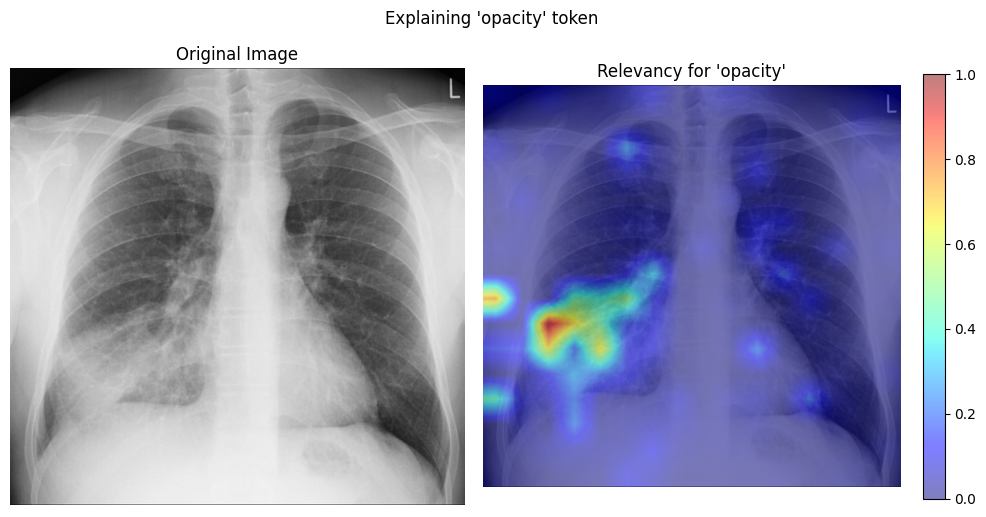

In [19]:
# Try to explain specific keywords
keywords_to_try = ['pneumonia', 'right', 'lung', 'consolidation', 'opacity']

for keyword in keywords_to_try:
    clear_memory()
    print(f"\nTrying keyword: '{keyword}'")

    try:
        result_kw = explain(
            model, processor, chest_xray, medical_prompt,
            keyword=keyword,
            max_new_tokens=50,
            use_global_only=True,
            device=DEVICE
        )

        regions, pt_right, pt_left = analyze_chest_regions(result_kw.image_relevancy)
        print(f"  Found! Pt RIGHT: {pt_right:.3f}, Pt LEFT: {pt_left:.3f}, Ratio: {pt_right/pt_left:.2f}x")

        # Visualize
        fig = visualize_explanation(
            chest_xray, result_kw,
            title=f"Explaining '{keyword}' token",
            show_text_relevancy=False
        )
        plt.show()

    except ValueError:
        print(f"  Keyword not in response")

## 9. Limitations and Summary <a name="9-summary"></a>

### Memory Optimization Strategies Used

1. **`use_global_only=True`**: Only process 5 global attention layers instead of all 34
2. **Reduced `max_new_tokens`**: Keep generated sequences short (30-50 tokens)
3. **Aggressive cache clearing**: `clear_memory()` between operations
4. **Single forward/backward pass**: No retained computation graph
5. **Incremental processing**: Process and discard each layer's attention

### If You Still Get OOM Errors

Try:
- Reduce `max_new_tokens` to 20-30
- Always use `use_global_only=True`
- Restart runtime between analyses
- Use a smaller batch of images

### Limitations of the Method

1. **Shows "where" not "why"**: Attention shows what regions influenced the output, not how the model interpreted them
2. **Approximation**: Using only global layers is faster but may miss some local patterns
3. **Token-level**: Explanations are per-token; full response explanation requires aggregation

### Critical Implementation Detail

For causal LMs, to explain token at position `p`:
```python
logit_position = p - 1
target_token_id = input_ids[0, p]  # Actual token, NOT argmax
target_logit = logits[0, logit_position, target_token_id]
```

In [ ]:
# Final cleanup
clear_memory()
print_memory("Final state")
print("\nTutorial complete!")